In [ ]:
import os
import io
import base64
import math
from typing import List, Dict, Any, Optional, Tuple

import cv2
import numpy as np
from PIL import Image

from openai import OpenAI
from openai import BadRequestError

import matplotlib.pyplot as plt

import torch

from interpretation.submodular_vision import MLLMSubModularExplanationVision
from interpretation.efficient_attribution import EfficientMLLMSubModularExplanationVision

from utils import SubRegionDivision
from visualization.visualization import visualization_mllm, visualization_mllm_with_object
import torchvision.transforms.functional as TF

# os.environ["HTTP_PROXY"]  = "http://127.0.0.1:7890"
# os.environ["HTTPS_PROXY"] = "http://127.0.0.1:7890"
# os.environ["ALL_PROXY"]   = "socks5://127.0.0.1:7890"

In [14]:
def imshow(img):
    """
    Visualizing images inside jupyter notebook
    """
    plt.axis('off')
    if len(img.shape)==3:
        img = img[:,:,::-1] 	# transform image to rgb
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

In [2]:
# =========================================================
# 0) cv2(BGR) -> data URL
# =========================================================
def cv2_bgr_to_data_url(img_bgr: np.ndarray, image_fmt: str = "JPEG", quality: int = 90) -> str:
    if img_bgr is None:
        raise ValueError("img_bgr is None")
    if img_bgr.ndim != 3 or img_bgr.shape[2] != 3:
        raise ValueError(f"Expected (H,W,3) BGR, got {img_bgr.shape}")

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(img_rgb.astype(np.uint8), mode="RGB")

    buf = io.BytesIO()
    if image_fmt.upper() in ["JPG", "JPEG"]:
        pil.save(buf, format="JPEG", quality=quality, optimize=True)
        mime = "image/jpeg"
    elif image_fmt.upper() == "PNG":
        pil.save(buf, format="PNG")
        mime = "image/png"
    else:
        raise ValueError("image_fmt must be JPEG or PNG")

    b64 = base64.b64encode(buf.getvalue()).decode("utf-8")
    return f"data:{mime};base64,{b64}"


# =========================================================
# 1) Parse helpers
# =========================================================
def _get(obj: Any, key: str, default=None):
    if isinstance(obj, dict):
        return obj.get(key, default)
    return getattr(obj, key, default)


def extract_first_output_text_block(resp: Any) -> Any:
    for item in _get(resp, "output", []) or []:
        if _get(item, "type") == "message" and _get(item, "role") == "assistant":
            for c in _get(item, "content", []) or []:
                if _get(c, "type") == "output_text":
                    return c
    raise RuntimeError("No assistant output_text block in response.output")


def extract_output_text(resp: Any) -> str:
    # SDK convenience
    t = getattr(resp, "output_text", None)
    if t is not None:
        return t
    ot = extract_first_output_text_block(resp)
    return _get(ot, "text", "")


def extract_token_strs_from_response(resp: Any) -> List[str]:
    """
    token_strs for the whole generated output. Requires:
      top_logprobs>=1 and include message.output_text.logprobs
    """
    ot = extract_first_output_text_block(resp)
    lps = _get(ot, "logprobs", None) or []
    toks = []
    for e in lps:
        tok = _get(e, "token", None)
        if tok is not None:
            toks.append(tok)
    return toks


def extract_first_token_topk(resp: Any) -> Tuple[Optional[str], Optional[float], List[Tuple[str, float]]]:
    """
    For a response that generated some tokens, return topK for the FIRST generated token.
    """
    ot = extract_first_output_text_block(resp)
    lps = _get(ot, "logprobs", None) or []
    if not lps:
        return None, None, []

    first = lps[0]
    sampled_tok = _get(first, "token", None)
    sampled_lp = _get(first, "logprob", None)

    top = _get(first, "top_logprobs", None) or []
    topk = [(_get(c, "token"), float(_get(c, "logprob"))) for c in top if _get(c, "token") is not None]
    return sampled_tok, (float(sampled_lp) if sampled_lp is not None else None), topk


# =========================================================
# 2) Step1: run once (x,y) -> token_strs (z tokens)
# =========================================================
def step1_generate_token_strs_once_cv2(
    client: OpenAI,
    model: str,
    x_bgr: np.ndarray,
    y: str,
    *,
    max_output_tokens: int = 64,
    temperature: float = 0.0,
    image_fmt: str = "JPEG",
) -> Dict[str, Any]:
    x_url = cv2_bgr_to_data_url(x_bgr, image_fmt=image_fmt)

    resp = client.responses.create(
        model=model,
        input=[{
            "role": "user",
            "content": [
                {"type": "input_text", "text": y},
                {"type": "input_image", "image_url": x_url},
            ],
        }],
        temperature=temperature,
        max_output_tokens=max_output_tokens,
        top_logprobs=1,  # ensure token logprobs are computed
        include=["message.output_text.logprobs"],
    )

    return {
        "z_text": extract_output_text(resp),
        "token_strs": extract_token_strs_from_response(resp),
        "resp": resp,
    }


# =========================================================
# 3) Step2: approximate teacher forcing via "continue from prefix" prompt
# =========================================================
def score_probs_vector_from_cv2_token_strs_continuation(
    client: OpenAI,
    model: str,
    xprime_bgr,
    y: str,
    token_strs: List[str],
    *,
    top_k: int = 20,
    temperature: float = 0.0,
    image_fmt: str = "JPEG",
    max_output_tokens_min: int = 16,
    debug_first_k_steps: int = 0,
) -> List[float]:
    """
    Compute P(z_i | x', y, z_<i) where z_i are token strings from Step1.
    Key trick: put prefix_text at the END of the user text so continuation is within a single text span,
    avoiding message-boundary tokenization artifacts (e.g., ' cat' vs 'Cat').
    """
    if not token_strs:
        return []

    if max_output_tokens_min < 16:
        max_output_tokens_min = 16

    xprime_url = cv2_bgr_to_data_url(xprime_bgr, image_fmt=image_fmt)

    probs: List[float] = []
    prefix_text = ""

    # A tight developer instruction to make the model behave like a continuation engine
    # dev = (
    #     "You are a text continuation engine.\n"
    #     "Continue the text exactly from where it ends.\n"
    #     "Do not restart, do not explain, do not add quotes, headings, or any extra formatting.\n"
    #     "Just continue with the next tokens."
    # )

    for i, target_tok in enumerate(token_strs):
        # Put the prefix at the END of the prompt text (no delimiters after it).
        # Also keep the task instruction y, but keep it above so the *last* characters are prefix_text.
        # if prefix_text == "":
        #     user_text = f"{y}"
        # else:
        #     user_text = f"{y}\nYou have started: \'{prefix_text}\', please continue and don't restart"


        resp = client.responses.create(
            model=model,
            input=[
                # {"role": "developer", "content": [{"type": "input_text", "text": dev}]},
                {
                    "role": "system",
                    "content": (
                        "You are a text continuation engine.\n"
                        "Given a prefix already produced by the assistant, you must continue it.\n"
                        "Rules:\n"
                        "1) Output ONLY the continuation (suffix), NOT the prefix.\n"
                        "2) Do NOT repeat any part of the prefix.\n"
                        "3) Continue seamlessly as if it were the same sentence.\n"
                        "4) Start your output with the next token immediately (often a leading space).\n"
                    ),
                },
                {
                    "role": "user",
                    "content": [
                        {"type": "input_text", "text": y},
                        {"type": "input_image", "image_url": xprime_url},
                    ],
                },
                {"role": "assistant", "content": prefix_text}
            ],
            temperature=temperature,
            max_output_tokens=max_output_tokens_min,
            top_logprobs=top_k,
            include=["message.output_text.logprobs"],
        )

        sampled_tok, sampled_lp, topk = extract_first_token_topk(resp)

        p = 0.0
        for tok, lp in topk:
            if tok == target_tok or tok == target_tok.lstrip():
                p = math.exp(lp)
                break
        probs.append(p)

        # if i < debug_first_k_steps:
        #     print("\n==============================")
        #     print(f"i={i}")
        #     print("target_tok repr:", repr(target_tok))
        #     print("prefix last 60 repr:", repr(prefix_text[-60:]))
        #     print("TOP-20 candidates:")
        #     for r, (tok, lp) in enumerate(topk[:20], 1):
        #         print(f"{r:02d}  tok={repr(tok)}  logprob={lp:.4f}  prob={math.exp(lp):.3e}")
        #     print("sampled_tok:", repr(sampled_tok), "sampled_lp:", sampled_lp)

        # advance prefix using the *ground-truth* token string
        prefix_text += target_tok

    return probs

In [3]:
image_path = "./examples/cat_on_a_tree.jpg"
text_prompt = "Describe the image in one factual English sentence of no more than 10 words. Do not include information that is not clearly visible."

In [ ]:
client = OpenAI(
    api_key="XXXXXXXX",     # Add yours
    base_url="https://api.openai.com/v1"
    )

model = "gpt-5.2"  # replace with your vision-capable model

In [5]:
y = text_prompt
x = cv2.imread(image_path)

# Step1: compute generated_ids once
out1 = step1_generate_token_strs_once_cv2(client, model, x, y, max_output_tokens=64)
token_strs = out1["token_strs"]
print("z_text:", out1["z_text"])
print("N tokens:", len(token_strs))
print("first 10 tokens:", token_strs[:10])

z_text: A cat sits among banana leaves and green bananas.
N tokens: 10
first 10 tokens: ['A', ' cat', ' sits', ' among', ' banana', ' leaves', ' and', ' green', ' bananas', '.']


In [6]:
# x' = x (sanity)
probs_same = score_probs_vector_from_cv2_token_strs_continuation(
    client, model, x, y, token_strs,
    top_k=20,
    max_output_tokens_min=16,
    debug_first_k_steps=3,
)
print("nonzero:", sum(p > 0 for p in probs_same), "/", len(probs_same))
print("first 10 probs:", probs_same[:10])

nonzero: 10 / 10
first 10 probs: [0.8144143605931908, 0.9847701650613327, 0.9033366339174683, 0.24915178248894052, 0.9787470947582971, 0.41579663351313806, 0.35388615981874677, 0.5741646942711515, 0.9360709538334593, 0.9481581175221002]


In [6]:
class GPT(torch.nn.Module):
    def __init__(self,
                 client,
                 model):
        super().__init__()
        self.client = client
        self.model = model
        
        self.device = "cuda"
        
    def forward(self, image):
        """_summary_

        Args:
            image: PIL format
        """
        if isinstance(image, torch.Tensor):
            if image.shape[-1] == 3:
                image_tensor = image[..., [2, 1, 0]]  # BGR → RGB
                image_tensor = image_tensor.permute(2, 0, 1)
                image_tensor = image_tensor.clamp(0, 255).byte()
                image = TF.to_pil_image(image_tensor)
                
                image = cv2.cvtColor(np.asarray(image),cv2.COLOR_RGB2BGR)
                
        probs_vec = score_probs_vector_from_cv2_token_strs_continuation(
            self.client, 
            self.model, 
            image, 
            self.y, 
            self.token_strs,
            top_k=20,
            max_output_tokens_min=16,
            debug_first_k_steps=3,
        )
        
        return torch.tensor(probs_vec, dtype=torch.float32).to(self.device)#probs_vec

In [7]:
gpt = GPT(client, model)
gpt.y = y
gpt.token_strs = token_strs

In [8]:
# Image division
image = cv2.imread(image_path)
    
# Sub-region division
region_size = int((image.shape[0] * image.shape[1] / 36) ** 0.5)
V_set = SubRegionDivision(image, region_size = region_size)

In [10]:
explainer = EfficientMLLMSubModularExplanationVision(
    gpt,
    search_scope = 8,
    pending_samples = 4,
    update_step = 10
)

cuda


In [11]:
## Begin to explain
S_set, saved_json_file = explainer(image, V_set)

 55%|█████▍    | 18/33 [1:59:58<1:39:58, 399.93s/it]


In [23]:
saved_json_file["words"] = ['A', ' cat', ' sits', ' among', ' banana', ' leaves', ' and', ' green', ' bananas', '.']

saved_json_file["smdl_score"] = (np.array(saved_json_file["insertion_score"]) + 1 - np.array(saved_json_file["deletion_score"])).tolist()

import json

np.save(
    "GPT.npy", np.array(S_set)
)
with open(
    "GPT.json", "w") as f:
    f.write(json.dumps(saved_json_file, ensure_ascii=False, indent=4, separators=(',', ':')))

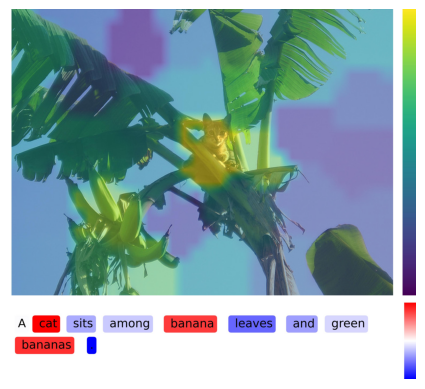

In [ ]:
## Visualization
visualization_mllm(image_path, S_set, saved_json_file, save_path="examples/gpt_visualization.jpg")
sentence_level_visualization_img = cv2.imread("examples/gpt_visualization.jpg")
imshow(sentence_level_visualization_img)